In [2]:
# ==================== 평가 설정 ====================
# Train/Validation 분할 기준 시간 (초 단위)
TRAIN_TIME_SPLIT = 3600  # 60분 (0~60분: train, 60분~: validation)

# 모델 및 입력 타입 순서 (그래프 표시 순서)
MODEL_ORDER = ["Markov", "LSTM", "1D-CNN", "RandomForest"]
INPUT_ORDER = ["RRC-only", "traffic", "RRC+traffic"]

# 색상 맵 (입력 타입별 그래프 색상)
COLOR_MAP = {
    "RRC-only": "gray",
    "traffic": "steelblue", 
    "RRC+traffic": "crimson"
}

# 히트맵 설정
HEATMAP_COLORMAP = 'YlOrRd'  # Yellow-Orange-Red 컬러맵
HEATMAP_VMIN = 0.0
HEATMAP_VMAX = 1.0

# 그래프 저장 DPI
FIGURE_DPI = 300

print("✅ 설정 완료:")
print(f"   - Train/Val split: {TRAIN_TIME_SPLIT}초 ({TRAIN_TIME_SPLIT//60}분)")
print(f"   - Model order: {MODEL_ORDER}")
print(f"   - Input order: {INPUT_ORDER}")
print(f"   - Colormap: {HEATMAP_COLORMAP}")

✅ 설정 완료:
   - Train/Val split: 3600초 (60분)
   - Model order: ['Markov', 'LSTM', '1D-CNN', 'RandomForest']
   - Input order: ['RRC-only', 'traffic', 'RRC+traffic']
   - Colormap: YlOrRd


## 0) 설정 상수 (Configuration)

# RRC State Prediction - Model Evaluation

모든 학습된 모델(Markov, LSTM, 1D-CNN, RandomForest)을 평가하고 결과를 비교합니다.

## 1) 라이브러리 임포트 및 경로 설정

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import os
import traceback
import warnings
import gc

import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

# 경로 설정 (notebooks 폴더에서 실행 시 프로젝트 루트로 이동)
current_folder = Path(os.getcwd()).name
if current_folder in ["src", "notebooks"]:
    BASE_DIR = Path(os.getcwd()).parent
else:
    BASE_DIR = Path(os.getcwd())

PROCESSED_DIR = BASE_DIR / "data" / "processed" / "processed_testbed"
RESULTS_DIR = BASE_DIR / "artifacts" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 에러 로그 파일 경로
ERROR_LOG_PATH = RESULTS_DIR / "evaluation_errors.log"

print("BASE_DIR:", BASE_DIR)
print("Results dir:", RESULTS_DIR)
print("Current working dir:", os.getcwd())
print("Error log:", ERROR_LOG_PATH)

BASE_DIR: c:\Users\dbdnj\Desktop\rrc_analysis_project
Results dir: c:\Users\dbdnj\Desktop\rrc_analysis_project\artifacts\results
Current working dir: c:\Users\dbdnj\Desktop\rrc_analysis_project\notebooks
Error log: c:\Users\dbdnj\Desktop\rrc_analysis_project\artifacts\results\evaluation_errors.log


## 2) 평가 및 시각화 함수 정의

In [4]:
def log_error(error_msg, error_log_path=None):
    """에러 메시지를 콘솔과 파일에 기록"""
    print(error_msg)
    if error_log_path:
        with open(error_log_path, 'a', encoding='utf-8') as f:
            f.write(f"\n{error_msg}\n")


def print_result(name, y_true, y_pred):
    """성능 지표 계산 및 출력"""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n[{name}]")
    print(f"Accuracy : {acc:.6f}")
    print(f"Macro F1 : {f1:.6f}")
    print("Confusion Matrix:")
    print(cm)
    return acc, f1, cm


def safe_metrics(name, y_true, y_pred):
    """전환 이벤트가 0개일 경우 NaN 반환"""
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    if len(y_true) == 0:
        print(f"\n[{name}] transition events = 0 -> metrics = NaN")
        return np.nan, np.nan, np.zeros((2, 2), dtype=int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm


def load_all_sessions(processed_dir=PROCESSED_DIR):
    """전처리된 CSV 파일들을 로드하여 하나의 DataFrame으로 통합"""
    dfs = []
    for csv_path in processed_dir.glob("*.csv"):
        df = pd.read_csv(csv_path)
        df = df.sort_values("time_sec")
        df["session_id"] = csv_path.stem
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


def fit_markov_from_df(df: pd.DataFrame):
    """Markov Chain 전이 행렬 학습 (세션 경계 고려, Laplace smoothing 적용)"""
    d = df.sort_values(["session_id", "time_sec"]).reset_index(drop=True)
    r = d["rrc_state"].to_numpy().astype(int)
    sid = d["session_id"].to_numpy()

    counts = np.zeros((2, 2), dtype=np.float64)

    for i in range(1, len(r)):
        if sid[i] != sid[i - 1]:  # 세션 경계 제외
            continue
        s = r[i - 1]
        t = r[i]
        if s in (0, 1) and t in (0, 1):
            counts[s, t] += 1

    counts += 1.0  # Laplace smoothing
    row_sums = counts.sum(axis=1, keepdims=True)
    trans_mat = counts / row_sums
    return trans_mat


def eval_markov_nextstate(df: pd.DataFrame, trans_mat, name="Markov (RRC-only)"):
    """Markov Chain 기반 다음 상태 예측 평가"""
    d = df.sort_values(["session_id", "time_sec"]).reset_index(drop=True)
    r = d["rrc_state"].to_numpy().astype(int)
    sid = d["session_id"].to_numpy()

    y_true, y_pred = [], []
    for i in range(1, len(r)):
        if sid[i] != sid[i - 1]:  # 세션 경계 제외
            continue
        prev_s = r[i - 1]
        cur_t = r[i]
        if prev_s not in (0, 1) or cur_t not in (0, 1):
            continue
        pred = int(np.argmax(trans_mat[prev_s]))
        y_true.append(cur_t)
        y_pred.append(pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return print_result(name, y_true, y_pred)


def markov_transition_only_from_val_df(val_df, trans_mat):
    """Markov 전환 이벤트만 평가 (상태가 실제로 변한 시점만)"""
    d = val_df.sort_values(["session_id", "time_sec"]).reset_index(drop=True)
    r = d["rrc_state"].to_numpy().astype(int)
    sid = d["session_id"].to_numpy()

    y_true, y_pred = [], []
    for i in range(1, len(r)):
        if sid[i] != sid[i - 1]:
            continue

        prev_s = r[i - 1]
        cur_t = r[i]

        if prev_s not in (0, 1) or cur_t not in (0, 1):
            continue

        if cur_t == prev_s:  # 전환 없음 -> 제외
            continue

        pred = int(np.argmax(trans_mat[prev_s]))
        y_true.append(cur_t)
        y_pred.append(pred)

    return np.array(y_true), np.array(y_pred)


def filter_transition_events(y_true, y_pred):
    """일반 모델의 전환 이벤트만 필터링 (y_true[t] != y_true[t-1])"""
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    if len(y_true) < 2:
        return y_true[:0], y_pred[:0]

    idx = np.where(y_true[1:] != y_true[:-1])[0] + 1
    return y_true[idx], y_pred[idx]


def plot_cm_heatmap(cm, title, save_path):
    """Confusion Matrix 히트맵 생성 (정규화 + 카운트 표시)"""
    cm = np.asarray(cm).astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0)

    fig, ax = plt.subplots(figsize=(4.2, 4.2))
    im = ax.imshow(cm_norm, interpolation="nearest", cmap=HEATMAP_COLORMAP, 
                   vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Idle(0)", "Conn(1)"])
    ax.set_yticklabels(["Idle(0)", "Conn(1)"])

    for i in range(2):
        for j in range(2):
            txt = f"{cm_norm[i, j]:.3f}\n({int(cm[i, j])})"
            color = 'white' if cm_norm[i, j] > 0.5 else 'black'
            ax.text(j, i, txt, ha="center", va="center", fontsize=9, color=color, fontweight='bold')

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Count', rotation=270, labelpad=15)
    plt.tight_layout()
    fig.savefig(save_path, dpi=FIGURE_DPI, bbox_inches='tight')
    display(fig)
    plt.close(fig)


def load_model_safe(model_path, model_name, error_log_path=None):
    """모델 안전하게 로드 (상세한 에러 처리)"""
    try:
        if not model_path.exists():
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
        
        model = load_model(model_path, compile=False)
        return model, None
        
    except FileNotFoundError as e:
        error_msg = f"   ✗ {model_name} - 파일 없음: {e}"
        log_error(error_msg, error_log_path)
        return None, str(e)
        
    except Exception as e:
        error_msg = f"   ✗ {model_name} - 로드 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
        log_error(error_msg, error_log_path)
        return None, str(e)


def eval_transition_only_general(name, y_true, y_pred, results_dir):
    """일반 모델(LSTM/CNN/RF)의 전환 이벤트 평가"""
    yt, yp = filter_transition_events(y_true, y_pred)
    n_tr = len(yt)

    acc, f1, cm = safe_metrics(f"{name} [transition-only]", yt, yp)

    if n_tr > 0:
        print_result(f"{name} [transition-only]", yt, yp)

    fname = (
        name.lower()
        .replace(" ", "_")
        .replace("+", "plus")
        .replace("/", "_")
        .replace("(", "")
        .replace(")", "")
    )
    save_path = results_dir / f"cm_transition_{fname}.png"
    if n_tr > 0:
        plot_cm_heatmap(cm, f"{name} (transition-only)", save_path)

    return n_tr, acc, f1, cm


def eval_transition_only_markov(name, val_df, trans_mat, results_dir):
    """Markov의 전환 이벤트 평가"""
    yt, yp = markov_transition_only_from_val_df(val_df, trans_mat)
    n_tr = len(yt)

    acc, f1, cm = safe_metrics(f"{name} [transition-only]", yt, yp)
    if n_tr > 0:
        print_result(f"{name} [transition-only]", yt, yp)

    save_path = results_dir / "cm_transition_markov_rrc_only.png"
    if n_tr > 0:
        plot_cm_heatmap(cm, f"{name} (transition-only)", save_path)

    return n_tr, acc, f1, cm


def plot_transition_summary(trans_df, results_dir):
    """전환 이벤트 성능 비교 그래프 생성 (가로 막대 + 표)"""
    df = trans_df.copy()

    df["Model"] = pd.Categorical(df["Model"], categories=MODEL_ORDER, ordered=True)
    df["Input"] = pd.Categorical(df["Input"], categories=INPUT_ORDER, ordered=True)
    df = df.sort_values(["Input", "Model"])

    labels = df["Model"].astype(str) + " (" + df["Input"].astype(str) + ")"
    y_pos = np.arange(len(labels))

    colors = [COLOR_MAP[inp] for inp in df["Input"]]

    fig, (ax_bar, ax_table) = plt.subplots(
        nrows=2, ncols=1,
        figsize=(10, 16),
        gridspec_kw={"height_ratios": [2.5, 1]}
    )

    bar_width = 0.4
    ax_bar.barh(y_pos - bar_width/2, df["Accuracy"], bar_width,
                label="Accuracy", color=colors, alpha=0.9, edgecolor='black', linewidth=0.8)
    ax_bar.barh(y_pos + bar_width/2, df["MacroF1"], bar_width,
                label="Macro F1-score", color=colors, alpha=0.6, edgecolor='black', linewidth=0.8, hatch='///')

    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(labels, fontsize=16)
    ax_bar.set_xlabel("Score", fontsize=18)
    ax_bar.set_xlim(0.0, 1.05)
    ax_bar.set_title("Transition-only Model Comparison", fontsize=19, fontweight="bold")
    ax_bar.legend(loc="lower right", fontsize=15)
    ax_bar.grid(axis="x", alpha=0.3)
    ax_bar.tick_params(axis='x', labelsize=14)
    ax_bar.invert_yaxis()

    ax_table.axis("off")

    show_df = df.copy()
    show_df["Accuracy"] = show_df["Accuracy"].round(4)
    show_df["MacroF1"] = show_df["MacroF1"].round(4)

    table = ax_table.table(
        cellText=show_df.values,
        colLabels=show_df.columns,
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    plt.subplots_adjust(left=0.34, right=0.98, top=0.96, bottom=0.06, hspace=0.25)
    pos_tbl = ax_table.get_position()
    ax_table.set_position([0.02, pos_tbl.y0, 0.96, pos_tbl.height])
    fig.savefig(results_dir / "models_comparison_transition_only.png", dpi=FIGURE_DPI)
    display(fig)
    plt.close(fig)

## 3) 모델 평가 및 결과 생성

🚀 모델 평가 시작

[1/5] 📂 데이터 로드 중...
   ✓ Traffic-only X_val: (11723, 60, 4)
   ✓ RRC+Traffic X_val: (2231, 300, 5)

[2/5] 🔄 Markov Baseline 평가 중...
   - Train: 0~60분, Val: 60분~
   Transition matrix:
 [[0.99574902 0.00425098]
 [0.00987273 0.99012727]]

[Markov (RRC-only)]
Accuracy : 0.994185
Macro F1 : 0.992761
Confusion Matrix:
[[12858    50]
 [   54  4924]]
   ✓ Markov 평가 완료

[3/5] 📊 Traffic-only 모델 평가 중...
   [3-1] LSTM (traffic) 로드 및 평가...

[LSTM (traffic)]
Accuracy : 0.750405
Macro F1 : 0.617809
Confusion Matrix:
[[7851  382]
 [2544  946]]
   ✓ LSTM (traffic) 완료
   [3-2] 1D-CNN (traffic) 로드 및 평가...

[1D-CNN (traffic)]
Accuracy : 0.739828
Macro F1 : 0.686659
Confusion Matrix:
[[6751 1482]
 [1568 1922]]
   ✓ 1D-CNN (traffic) 완료
   [3-3] RandomForest (traffic) 로드 및 평가...

[RandomForest (traffic)]
Accuracy : 0.763883
Macro F1 : 0.675305
Confusion Matrix:
[[7539  694]
 [2074 1416]]
   ✓ RandomForest (traffic) 완료

[4/5] 📊 RRC+Traffic 모델 평가 중...
   [4-1] LSTM (RRC+traffic) 로드 및 평가...

[LSTM (

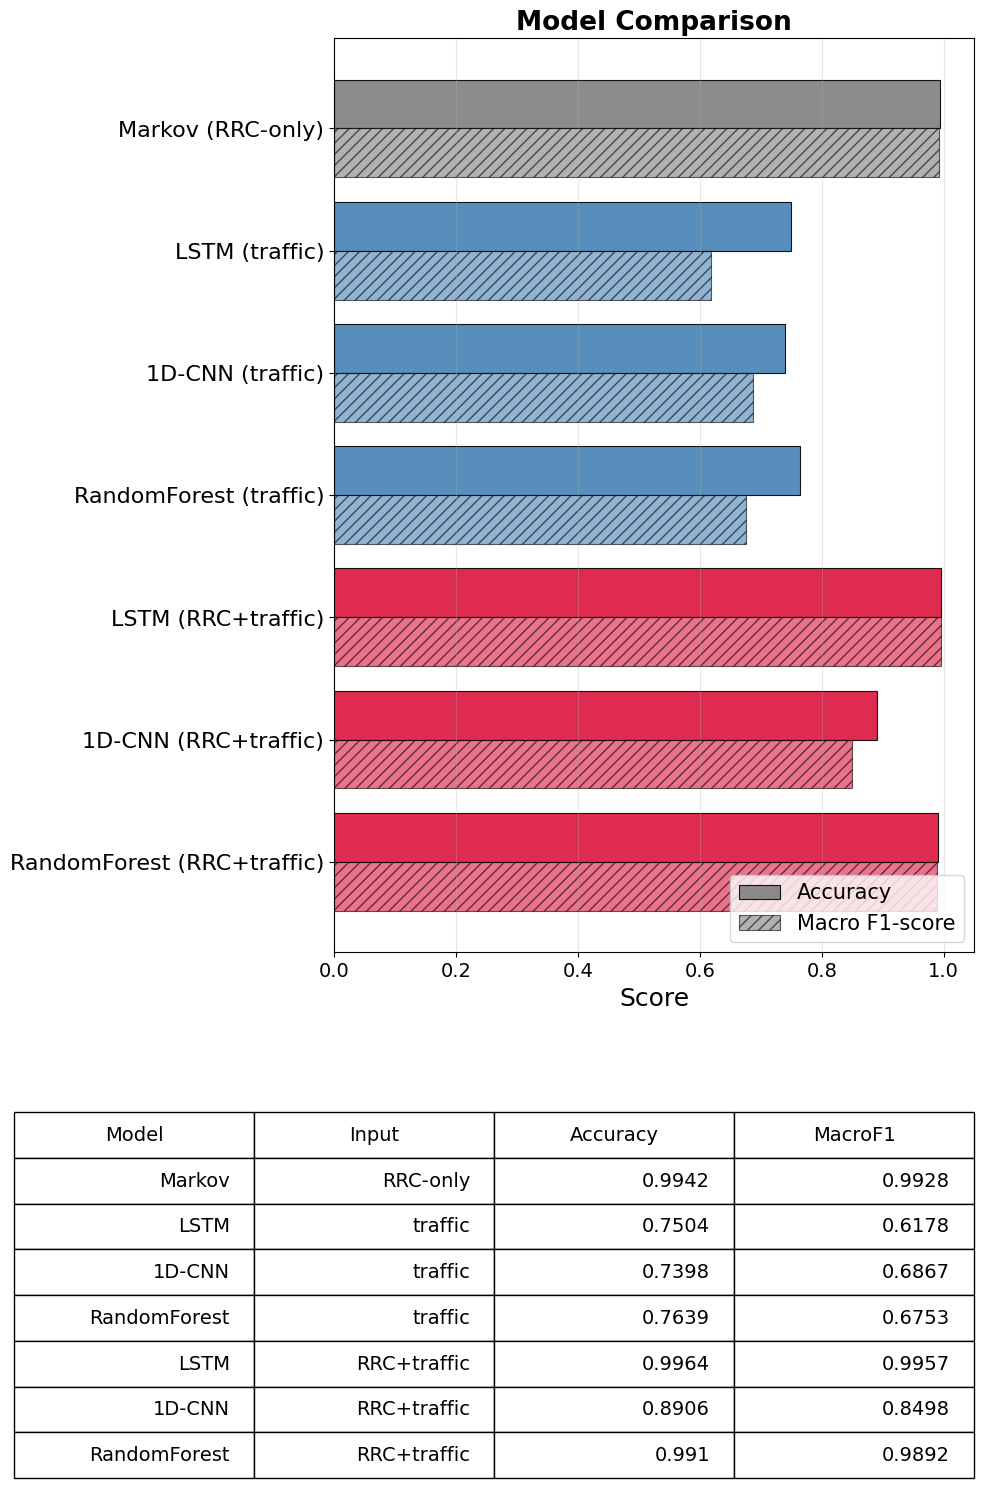


✓ 그래프 파일 저장 완료:
   - artifacts/results/models_comparison.png
   - artifacts/results/models_comparison_summary.csv

[5/5] 🔀 Transition-only 평가 (전환 이벤트만)

   [5-1] Markov (RRC-only) transition-only...

[Markov (RRC-only) [transition-only]]
Accuracy : 0.000000
Macro F1 : 0.000000
Confusion Matrix:
[[ 0 50]
 [54  0]]


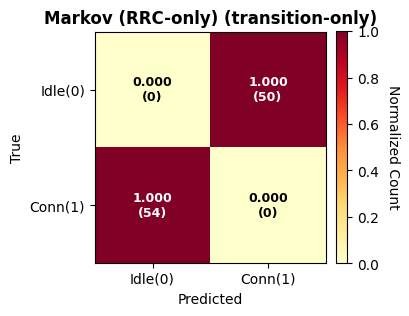


   [5-2] LSTM (traffic) transition-only...

[LSTM (traffic) [transition-only]]
Accuracy : 0.616780
Macro F1 : 0.566506
Confusion Matrix:
[[2322  104]
 [1755  670]]


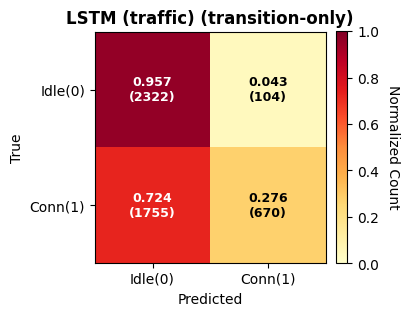


   [5-3] 1D-CNN (traffic) transition-only...

[1D-CNN (traffic) [transition-only]]
Accuracy : 0.684189
Macro F1 : 0.678397
Confusion Matrix:
[[1985  441]
 [1091 1334]]


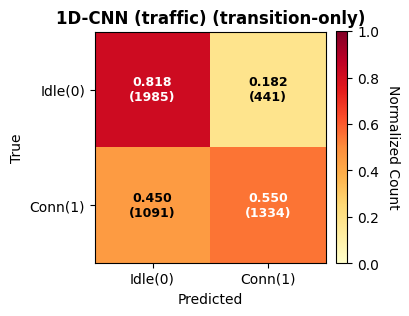


   [5-4] RandomForest (traffic) transition-only...

[RandomForest (traffic) [transition-only]]
Accuracy : 0.663781
Macro F1 : 0.640357
Confusion Matrix:
[[2229  197]
 [1434  991]]


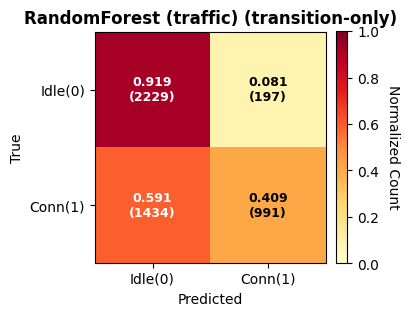


   [5-5] LSTM (RRC+traffic) transition-only...

[LSTM (RRC+traffic) [transition-only]]
Accuracy : 0.996696
Macro F1 : 0.996696
Confusion Matrix:
[[454   0]
 [  3 451]]


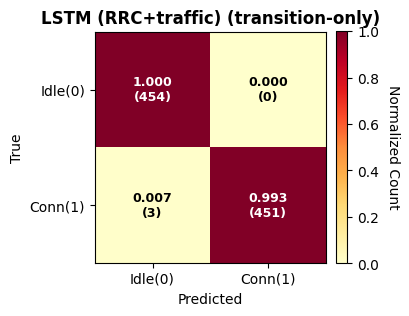


   [5-6] 1D-CNN (RRC+traffic) transition-only...

[1D-CNN (RRC+traffic) [transition-only]]
Accuracy : 0.818282
Macro F1 : 0.812383
Confusion Matrix:
[[452   2]
 [163 291]]


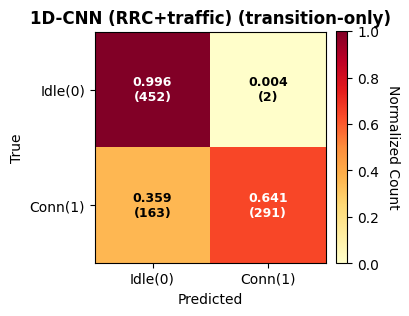


   [5-7] RandomForest (RRC+traffic) transition-only...

[RandomForest (RRC+traffic) [transition-only]]
Accuracy : 0.993392
Macro F1 : 0.993392
Confusion Matrix:
[[451   3]
 [  3 451]]


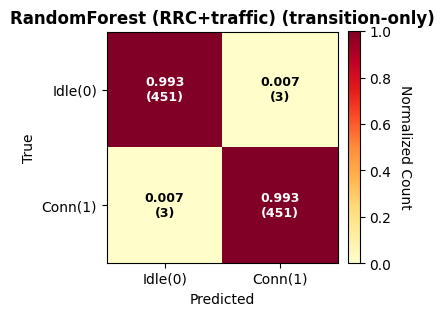


=== Transition-only Summary Table ===
       Model       Input  N_transitions  Accuracy  MacroF1
      Markov    RRC-only            104  0.000000 0.000000
        LSTM     traffic           4851  0.616780 0.566506
      1D-CNN     traffic           4851  0.684189 0.678397
RandomForest     traffic           4851  0.663781 0.640357
        LSTM RRC+traffic            908  0.996696 0.996696
      1D-CNN RRC+traffic            908  0.818282 0.812383
RandomForest RRC+traffic            908  0.993392 0.993392

✓ Transition-only 결과 저장 완료:
   - artifacts/results/eval_transition_only_summary.csv
   - artifacts/results/cm_transition_*.png

📊 Transition-only 비교 그래프 생성 중...


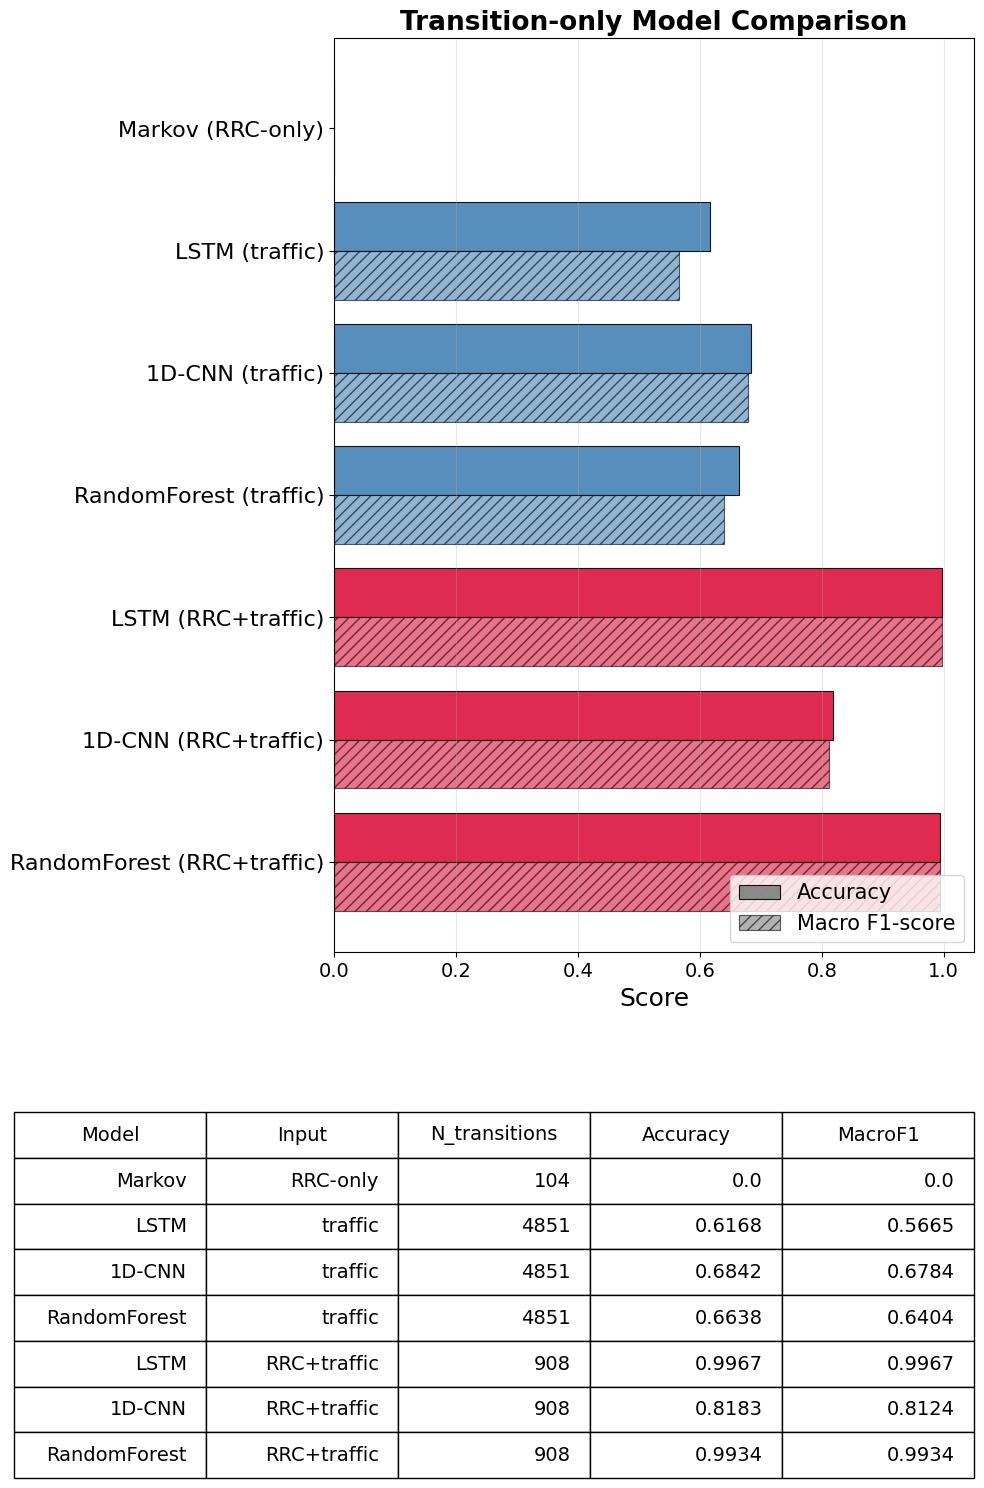

✓ artifacts/results/models_comparison_transition_only.png

✅ 모든 평가 완료!
🎉 모든 모델이 정상적으로 평가되었습니다!


In [5]:
# 에러 로그 파일 초기화
if ERROR_LOG_PATH.exists():
    ERROR_LOG_PATH.unlink()

print("="*80)
print("🚀 모델 평가 시작")
print("="*80)

# 평가 실패 모델 추적
failed_models = []

# ==================== 데이터 로드 ====================
print("\n[1/5] 📂 데이터 로드 중...")
try:
    traffic_npz = np.load(BASE_DIR / "data" / "processed" / "traffic_only_seq_dataset.npz")
    Xv_t = traffic_npz["X_val"]
    yv_t = traffic_npz["y_val"]
    print(f"   ✓ Traffic-only X_val: {Xv_t.shape}")
except FileNotFoundError as e:
    error_msg = f"   ✗ Traffic-only 데이터 파일을 찾을 수 없습니다: {e}"
    log_error(error_msg, ERROR_LOG_PATH)
    raise
except Exception as e:
    error_msg = f"   ✗ Traffic-only 데이터 로드 실패: {type(e).__name__}: {e}"
    log_error(error_msg, ERROR_LOG_PATH)
    raise

try:
    rrc_npz = np.load(BASE_DIR / "data" / "processed" / "seq_dataset.npz")
    Xv_r = rrc_npz["X_val"]
    yv_r = rrc_npz["y_val"]
    print(f"   ✓ RRC+Traffic X_val: {Xv_r.shape}")
except FileNotFoundError as e:
    error_msg = f"   ✗ RRC+Traffic 데이터 파일을 찾을 수 없습니다: {e}"
    log_error(error_msg, ERROR_LOG_PATH)
    raise
except Exception as e:
    error_msg = f"   ✗ RRC+Traffic 데이터 로드 실패: {type(e).__name__}: {e}"
    log_error(error_msg, ERROR_LOG_PATH)
    raise

# ==================== Markov Baseline ====================
print("\n[2/5] 🔄 Markov Baseline 평가 중...")
print(f"   - Train: 0~{TRAIN_TIME_SPLIT//60}분, Val: {TRAIN_TIME_SPLIT//60}분~")
try:
    full_df = load_all_sessions()
    train_df = full_df[full_df["time_sec"] < TRAIN_TIME_SPLIT].copy()
    val_df = full_df[full_df["time_sec"] >= TRAIN_TIME_SPLIT].copy()
    
    trans_mat = fit_markov_from_df(train_df)
    print("   Transition matrix:\n", trans_mat)
    
    markov_acc, markov_f1, markov_cm = eval_markov_nextstate(val_df, trans_mat, name="Markov (RRC-only)")
    print(f"   ✓ Markov 평가 완료")
except Exception as e:
    error_msg = f"   ✗ Markov 평가 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
    log_error(error_msg, ERROR_LOG_PATH)
    failed_models.append("Markov (RRC-only)")
    markov_acc = markov_f1 = np.nan
    markov_cm = np.zeros((2, 2))

# 메모리 정리
del train_df
gc.collect()

# ==================== Traffic-only 모델 평가 ====================
print("\n[3/5] 📊 Traffic-only 모델 평가 중...")

print("   [3-1] LSTM (traffic) 로드 및 평가...")
model, error = load_model_safe(
    BASE_DIR / "artifacts" / "models" / "lstm_traffic_best.keras",
    "LSTM (traffic)",
    ERROR_LOG_PATH
)
if model is not None:
    try:
        yv_t_pred_lstm = (model.predict(Xv_t, verbose=0) > 0.5).astype("int32").ravel()
        lstm_t_acc, lstm_t_f1, lstm_t_cm = print_result("LSTM (traffic)", yv_t, yv_t_pred_lstm)
        print(f"   ✓ LSTM (traffic) 완료")
    except Exception as e:
        error_msg = f"   ✗ LSTM (traffic) 예측 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
        log_error(error_msg, ERROR_LOG_PATH)
        failed_models.append("LSTM (traffic)")
        lstm_t_acc = lstm_t_f1 = np.nan
        lstm_t_cm = np.zeros((2, 2))
        yv_t_pred_lstm = np.zeros_like(yv_t)
    finally:
        del model
        gc.collect()
else:
    failed_models.append("LSTM (traffic)")
    lstm_t_acc = lstm_t_f1 = np.nan
    lstm_t_cm = np.zeros((2, 2))
    yv_t_pred_lstm = np.zeros_like(yv_t)

print("   [3-2] 1D-CNN (traffic) 로드 및 평가...")
model, error = load_model_safe(
    BASE_DIR / "artifacts" / "models" / "cnn1d_traffic_best.keras",
    "1D-CNN (traffic)",
    ERROR_LOG_PATH
)
if model is not None:
    try:
        yv_t_pred_cnn = (model.predict(Xv_t, verbose=0) > 0.5).astype("int32").ravel()
        cnn_t_acc, cnn_t_f1, cnn_t_cm = print_result("1D-CNN (traffic)", yv_t, yv_t_pred_cnn)
        print(f"   ✓ 1D-CNN (traffic) 완료")
    except Exception as e:
        error_msg = f"   ✗ 1D-CNN (traffic) 예측 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
        log_error(error_msg, ERROR_LOG_PATH)
        failed_models.append("1D-CNN (traffic)")
        cnn_t_acc = cnn_t_f1 = np.nan
        cnn_t_cm = np.zeros((2, 2))
        yv_t_pred_cnn = np.zeros_like(yv_t)
    finally:
        del model
        gc.collect()
else:
    failed_models.append("1D-CNN (traffic)")
    cnn_t_acc = cnn_t_f1 = np.nan
    cnn_t_cm = np.zeros((2, 2))
    yv_t_pred_cnn = np.zeros_like(yv_t)

print("   [3-3] RandomForest (traffic) 로드 및 평가...")
try:
    rf_model_path = BASE_DIR / "artifacts" / "models" / "rf_traffic_model.joblib"
    if not rf_model_path.exists():
        raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {rf_model_path}")
    
    rf_t = joblib.load(rf_model_path)
    Xv_t_flat = Xv_t.reshape(Xv_t.shape[0], -1)
    yv_t_pred_rf = rf_t.predict(Xv_t_flat)
    rf_t_acc, rf_t_f1, rf_t_cm = print_result("RandomForest (traffic)", yv_t, yv_t_pred_rf)
    print(f"   ✓ RandomForest (traffic) 완료")
    
    # 메모리 정리
    del rf_t, Xv_t_flat
    gc.collect()
except Exception as e:
    error_msg = f"   ✗ RandomForest (traffic) 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
    log_error(error_msg, ERROR_LOG_PATH)
    failed_models.append("RandomForest (traffic)")
    rf_t_acc = rf_t_f1 = np.nan
    rf_t_cm = np.zeros((2, 2))
    yv_t_pred_rf = np.zeros_like(yv_t)

# ==================== RRC+Traffic 모델 평가 ====================
print("\n[4/5] 📊 RRC+Traffic 모델 평가 중...")

print("   [4-1] LSTM (RRC+traffic) 로드 및 평가...")
model, error = load_model_safe(
    BASE_DIR / "artifacts" / "models" / "lstm_best.keras",
    "LSTM (RRC+traffic)",
    ERROR_LOG_PATH
)
if model is not None:
    try:
        yv_r_pred_lstm = (model.predict(Xv_r, verbose=0) > 0.5).astype("int32").ravel()
        lstm_r_acc, lstm_r_f1, lstm_r_cm = print_result("LSTM (RRC+traffic)", yv_r, yv_r_pred_lstm)
        print(f"   ✓ LSTM (RRC+traffic) 완료")
    except Exception as e:
        error_msg = f"   ✗ LSTM (RRC+traffic) 예측 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
        log_error(error_msg, ERROR_LOG_PATH)
        failed_models.append("LSTM (RRC+traffic)")
        lstm_r_acc = lstm_r_f1 = np.nan
        lstm_r_cm = np.zeros((2, 2))
        yv_r_pred_lstm = np.zeros_like(yv_r)
    finally:
        del model
        gc.collect()
else:
    failed_models.append("LSTM (RRC+traffic)")
    lstm_r_acc = lstm_r_f1 = np.nan
    lstm_r_cm = np.zeros((2, 2))
    yv_r_pred_lstm = np.zeros_like(yv_r)

print("   [4-2] 1D-CNN (RRC+traffic) 로드 및 평가...")
model, error = load_model_safe(
    BASE_DIR / "artifacts" / "models" / "cnn1d_best.keras",
    "1D-CNN (RRC+traffic)",
    ERROR_LOG_PATH
)
if model is not None:
    try:
        yv_r_pred_cnn = (model.predict(Xv_r, verbose=0) > 0.5).astype("int32").ravel()
        cnn_r_acc, cnn_r_f1, cnn_r_cm = print_result("1D-CNN (RRC+traffic)", yv_r, yv_r_pred_cnn)
        print(f"   ✓ 1D-CNN (RRC+traffic) 완료")
    except Exception as e:
        error_msg = f"   ✗ 1D-CNN (RRC+traffic) 예측 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
        log_error(error_msg, ERROR_LOG_PATH)
        failed_models.append("1D-CNN (RRC+traffic)")
        cnn_r_acc = cnn_r_f1 = np.nan
        cnn_r_cm = np.zeros((2, 2))
        yv_r_pred_cnn = np.zeros_like(yv_r)
    finally:
        del model
        gc.collect()
else:
    failed_models.append("1D-CNN (RRC+traffic)")
    cnn_r_acc = cnn_r_f1 = np.nan
    cnn_r_cm = np.zeros((2, 2))
    yv_r_pred_cnn = np.zeros_like(yv_r)

print("   [4-3] RandomForest (RRC+traffic) 로드 및 평가...")
try:
    rf_model_path = BASE_DIR / "artifacts" / "models" / "rf_model.joblib"
    if not rf_model_path.exists():
        raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {rf_model_path}")
    
    rf_r = joblib.load(rf_model_path)
    Xv_r_flat = Xv_r.reshape(Xv_r.shape[0], -1)
    yv_r_pred_rf = rf_r.predict(Xv_r_flat)
    rf_r_acc, rf_r_f1, rf_r_cm = print_result("RandomForest (RRC+traffic)", yv_r, yv_r_pred_rf)
    print(f"   ✓ RandomForest (RRC+traffic) 완료")
    
    # 메모리 정리
    del rf_r, Xv_r_flat
    gc.collect()
except Exception as e:
    error_msg = f"   ✗ RandomForest (RRC+traffic) 실패: {type(e).__name__}: {e}\n{traceback.format_exc()}"
    log_error(error_msg, ERROR_LOG_PATH)
    failed_models.append("RandomForest (RRC+traffic)")
    rf_r_acc = rf_r_f1 = np.nan
    rf_r_cm = np.zeros((2, 2))
    yv_r_pred_rf = np.zeros_like(yv_r)

# ==================== 전체 성능 요약 ====================
print("\n" + "="*80)
print("📈 전체 성능 요약")
print("="*80)

if failed_models:
    print(f"\n⚠️  평가 실패 모델 ({len(failed_models)}개):")
    for model_name in failed_models:
        print(f"   - {model_name}")
    print(f"\n상세 에러 로그: {ERROR_LOG_PATH.relative_to(BASE_DIR)}\n")

summary = [
    ("Markov",       "RRC-only",     markov_acc, markov_f1),
    ("LSTM",         "traffic",      lstm_t_acc, lstm_t_f1),
    ("1D-CNN",       "traffic",      cnn_t_acc,  cnn_t_f1),
    ("RandomForest", "traffic",      rf_t_acc,   rf_t_f1),
    ("LSTM",         "RRC+traffic",  lstm_r_acc, lstm_r_f1),
    ("1D-CNN",       "RRC+traffic",  cnn_r_acc,  cnn_r_f1),
    ("RandomForest", "RRC+traffic",  rf_r_acc,   rf_r_f1),
]
summary_df = pd.DataFrame(summary, columns=["Model", "Input", "Accuracy", "MacroF1"])

print("\n=== Summary Table ===")
print(summary_df.to_string(index=False))

# ==================== 전체 성능 비교 그래프 ====================
print("\n📊 성능 비교 그래프 생성 중...")
s = summary_df.copy()
s["Model"] = pd.Categorical(s["Model"], categories=MODEL_ORDER, ordered=True)
s["Input"] = pd.Categorical(s["Input"], categories=INPUT_ORDER, ordered=True)
s = s.sort_values(["Input", "Model"])

labels = s["Model"].astype(str) + " (" + s["Input"].astype(str) + ")"
y_pos = np.arange(len(labels))

colors = [COLOR_MAP[inp] for inp in s["Input"]]

fig, (ax_bar, ax_table) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 16),
    gridspec_kw={"height_ratios": [2.5, 1]}
)

bar_width = 0.4
ax_bar.barh(y_pos - bar_width/2, s["Accuracy"], bar_width,
            label="Accuracy", color=colors, alpha=0.9, edgecolor='black', linewidth=0.8)
ax_bar.barh(y_pos + bar_width/2, s["MacroF1"], bar_width,
            label="Macro F1-score", color=colors, alpha=0.6, edgecolor='black', linewidth=0.8, hatch='///')

ax_bar.set_yticks(y_pos)
ax_bar.set_yticklabels(labels, fontsize=16)
ax_bar.set_xlabel("Score", fontsize=18)
ax_bar.set_xlim(0.0, 1.05)
ax_bar.set_title("Model Comparison", fontsize=19, fontweight="bold")
ax_bar.legend(loc="lower right", fontsize=15)
ax_bar.grid(axis="x", alpha=0.3)
ax_bar.tick_params(axis='x', labelsize=14)
ax_bar.invert_yaxis()

ax_table.axis("off")
table = ax_table.table(
    cellText=s.round(4).values,
    colLabels=s.columns,
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(14)

plt.subplots_adjust(left=0.34, right=0.98, top=0.96, bottom=0.06, hspace=0.25)
pos_tbl = ax_table.get_position()
ax_table.set_position([0.02, pos_tbl.y0, 0.96, pos_tbl.height])
fig.savefig(RESULTS_DIR / "models_comparison.png", dpi=FIGURE_DPI)
display(fig)
plt.close(fig)

summary_df.to_csv(RESULTS_DIR / "models_comparison_summary.csv", index=False, encoding="utf-8-sig")

print("\n✓ 그래프 파일 저장 완료:")
print("   - artifacts/results/models_comparison.png")
print("   - artifacts/results/models_comparison_summary.csv")

# ==================== Transition-only 평가 ====================
print("\n" + "="*80)
print("[5/5] 🔀 Transition-only 평가 (전환 이벤트만)")
print("="*80)

trans_rows = []

print("\n   [5-1] Markov (RRC-only) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_markov("Markov (RRC-only)", val_df, trans_mat, RESULTS_DIR)
trans_rows.append(("Markov", "RRC-only", n_tr, acc, f1))

print("\n   [5-2] LSTM (traffic) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_general("LSTM (traffic)", yv_t, yv_t_pred_lstm, RESULTS_DIR)
trans_rows.append(("LSTM", "traffic", n_tr, acc, f1))

print("\n   [5-3] 1D-CNN (traffic) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_general("1D-CNN (traffic)", yv_t, yv_t_pred_cnn, RESULTS_DIR)
trans_rows.append(("1D-CNN", "traffic", n_tr, acc, f1))

print("\n   [5-4] RandomForest (traffic) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_general("RandomForest (traffic)", yv_t, yv_t_pred_rf, RESULTS_DIR)
trans_rows.append(("RandomForest", "traffic", n_tr, acc, f1))

print("\n   [5-5] LSTM (RRC+traffic) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_general("LSTM (RRC+traffic)", yv_r, yv_r_pred_lstm, RESULTS_DIR)
trans_rows.append(("LSTM", "RRC+traffic", n_tr, acc, f1))

print("\n   [5-6] 1D-CNN (RRC+traffic) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_general("1D-CNN (RRC+traffic)", yv_r, yv_r_pred_cnn, RESULTS_DIR)
trans_rows.append(("1D-CNN", "RRC+traffic", n_tr, acc, f1))

print("\n   [5-7] RandomForest (RRC+traffic) transition-only...")
n_tr, acc, f1, cm = eval_transition_only_general("RandomForest (RRC+traffic)", yv_r, yv_r_pred_rf, RESULTS_DIR)
trans_rows.append(("RandomForest", "RRC+traffic", n_tr, acc, f1))

trans_df = pd.DataFrame(trans_rows, columns=["Model", "Input", "N_transitions", "Accuracy", "MacroF1"])

print("\n=== Transition-only Summary Table ===")
print(trans_df.to_string(index=False))

trans_df.to_csv(RESULTS_DIR / "eval_transition_only_summary.csv", index=False, encoding="utf-8-sig")
print("\n✓ Transition-only 결과 저장 완료:")
print("   - artifacts/results/eval_transition_only_summary.csv")
print("   - artifacts/results/cm_transition_*.png")

print("\n📊 Transition-only 비교 그래프 생성 중...")
plot_transition_summary(trans_df, RESULTS_DIR)
print("✓ artifacts/results/models_comparison_transition_only.png")

# 최종 메모리 정리
del full_df, val_df, Xv_t, yv_t, Xv_r, yv_r
del yv_t_pred_lstm, yv_t_pred_cnn, yv_t_pred_rf
del yv_r_pred_lstm, yv_r_pred_cnn, yv_r_pred_rf
gc.collect()

print("\n" + "="*80)
print("✅ 모든 평가 완료!")
if failed_models:
    print(f"⚠️  {len(failed_models)}개 모델 평가 실패 (상세 로그: {ERROR_LOG_PATH.relative_to(BASE_DIR)})")
else:
    print("🎉 모든 모델이 정상적으로 평가되었습니다!")
print("="*80)

## 4) 평가 결과 요약

In [6]:
from datetime import datetime

print("="*80)
print("📋 평가 결과 요약")
print("="*80)

# ==================== 생성된 파일 목록 ====================
print("\n📁 생성된 파일 목록:")
print("-" * 80)

result_files = sorted(RESULTS_DIR.glob("*"))
total_size = 0

for p in result_files:
    if p.is_file():
        size_bytes = p.stat().st_size
        size_kb = size_bytes / 1024
        mod_time = datetime.fromtimestamp(p.stat().st_mtime).strftime("%Y-%m-%d %H:%M:%S")
        total_size += size_bytes
        
        # 파일 타입별 아이콘
        if p.suffix == '.png':
            icon = "🖼️ "
        elif p.suffix == '.csv':
            icon = "📊"
        elif p.suffix == '.log':
            icon = "📝"
        else:
            icon = "📄"
        
        print(f"{icon} {p.name:50s} {size_kb:>8.1f} KB  ({mod_time})")

print("-" * 80)
print(f"총 {len(result_files)}개 파일, 전체 크기: {total_size/1024:.1f} KB\n")

# ==================== Top-3 모델 성능 ====================
print("\n🏆 Top-3 모델 (Accuracy 기준):")
print("-" * 80)

# NaN이 아닌 값만 필터링
valid_summary = summary_df[~summary_df['Accuracy'].isna()].copy()

if len(valid_summary) > 0:
    top3 = valid_summary.nlargest(3, 'Accuracy')
    
    for idx, (i, row) in enumerate(top3.iterrows(), 1):
        medal = ["🥇", "🥈", "🥉"][idx-1]
        print(f"{medal} #{idx}: {row['Model']:12s} ({row['Input']:12s}) - "
              f"Accuracy: {row['Accuracy']:.4f}, Macro F1: {row['MacroF1']:.4f}")
else:
    print("⚠️  유효한 평가 결과가 없습니다.")

# ==================== 주요 지표 요약 ====================
print("\n\n📈 전체 모델 성능 요약:")
print("-" * 80)

if len(valid_summary) > 0:
    # 통계 계산
    avg_acc = valid_summary['Accuracy'].mean()
    avg_f1 = valid_summary['MacroF1'].mean()
    max_acc = valid_summary['Accuracy'].max()
    max_f1 = valid_summary['MacroF1'].max()
    min_acc = valid_summary['Accuracy'].min()
    min_f1 = valid_summary['MacroF1'].min()
    
    stats_df = pd.DataFrame({
        '지표': ['Accuracy', 'Macro F1'],
        '평균': [f'{avg_acc:.4f}', f'{avg_f1:.4f}'],
        '최댓값': [f'{max_acc:.4f}', f'{max_f1:.4f}'],
        '최솟값': [f'{min_acc:.4f}', f'{min_f1:.4f}']
    })
    
    print(stats_df.to_string(index=False))
    
    # 입력 타입별 평균 성능
    print("\n\n📊 입력 타입별 평균 성능:")
    print("-" * 80)
    
    input_perf = valid_summary.groupby('Input')[['Accuracy', 'MacroF1']].mean()
    input_perf = input_perf.round(4)
    print(input_perf.to_string())

# ==================== Transition-only 성능 요약 ====================
if 'trans_df' in locals():
    print("\n\n🔀 Transition-only Top-3:")
    print("-" * 80)
    
    valid_trans = trans_df[~trans_df['Accuracy'].isna()].copy()
    
    if len(valid_trans) > 0:
        top3_trans = valid_trans.nlargest(3, 'Accuracy')
        
        for idx, (i, row) in enumerate(top3_trans.iterrows(), 1):
            medal = ["🥇", "🥈", "🥉"][idx-1]
            print(f"{medal} #{idx}: {row['Model']:12s} ({row['Input']:12s}) - "
                  f"Accuracy: {row['Accuracy']:.4f}, Macro F1: {row['MacroF1']:.4f}, "
                  f"N_transitions: {int(row['N_transitions'])}")

# ==================== 실패한 모델 정보 ====================
if failed_models:
    print("\n\n⚠️  평가 실패 모델:")
    print("-" * 80)
    for model_name in failed_models:
        print(f"   ❌ {model_name}")
    print(f"\n📝 상세 에러 로그: {ERROR_LOG_PATH.relative_to(BASE_DIR)}")
else:
    print("\n\n✅ 모든 모델이 성공적으로 평가되었습니다!")

print("\n" + "="*80)
print(f"⏱️  평가 완료 시각: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

📋 평가 결과 요약

📁 생성된 파일 목록:
--------------------------------------------------------------------------------
🖼️  cm_transition_1d-cnn_rrcplustraffic.png                79.5 KB  (2025-12-17 16:16:34)
🖼️  cm_transition_1d-cnn_traffic.png                       79.4 KB  (2025-12-17 16:16:33)
🖼️  cm_transition_lstm_rrcplustraffic.png                  75.1 KB  (2025-12-17 16:16:33)
🖼️  cm_transition_lstm_traffic.png                         79.1 KB  (2025-12-17 16:16:33)
🖼️  cm_transition_markov_rrc_only.png                      73.3 KB  (2025-12-17 16:16:32)
🖼️  cm_transition_randomforest_rrcplustraffic.png          81.4 KB  (2025-12-17 16:16:34)
🖼️  cm_transition_randomforest_traffic.png                 82.2 KB  (2025-12-17 16:16:33)
📊 eval_transition_only_summary.csv                        0.4 KB  (2025-12-17 16:16:34)
🖼️  models_comparison.png                                 405.4 KB  (2025-12-17 16:16:32)
📊 models_comparison_summary.csv                           0.4 KB  (2025-12-17 16:16:32